# [Computational Social Science]
## 5-3 Text Feature Engineering and Classification - Student Version

In this lab we will use the techniques we covered so far to engineer text features and train a classification algorithm.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [1]:
# load libraries
# ----------
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# settings
%matplotlib inline

## Data

<img src = "../../images/cfpb_logo.png"/>

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). Picking up from where we left off last time, we'll focus on predicting whether a consumer complaint narrative is talking about a "checkings or savings account" issue or a "student loan" issue.

In [2]:
import os
print(os.getcwd())
print(os.listdir('./data')) 

/Users/beatrice/git/CSS2024/5 Natural Language Processing/5-3 Text Feature Engineering and Classification
['.DS_Store', 'CFPB 2020 Complaints.csv']


In [10]:
# load the data
# ----------
# load data
cfpb = pd.read_csv("./data/CFPB 2020 Complaints.csv")

# drop missing on "Consumer complaint narrative" feature and reset the index bc we've dropped
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])

# filtering to keep only savings and student loan products
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]

# filtering to keep the first 1000 rows
cfpb = cfpb[:1000]

/var/folders/f5/cxwzf1714jl8np8by14r5y8m0000gn/T/ipykernel_39985/2293943278.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb = pd.read_csv("./data/CFPB 2020 Complaints.csv")


## Text Preprocessing

Before we do any feature engineering or classification, we should first preprocess our text. Let's start by adding custom stop words and defining our custom `rem_punc_stop()` function:

In [11]:
# add a few words analysis-specific words to our Stop Words
# ----------
STOP_WORDS = STOP_WORDS.union({"XX", "XXXX","XXXXXXXX"})

# what are some ways we might check to see if these stop words were added
# ----------

# option 1
print(STOP_WORDS)

# option 2
print(len(STOP_WORDS))

{'with', 'whom', 'eleven', 'see', 'would', 'perhaps', 'they', 'whereupon', 'less', 'so', 'done', 'together', 'toward', '’s', 'beside', 'to', 'amongst', 'she', 'n’t', 'eight', 'latter', 'nine', 'meanwhile', 'was', 'now', 'give', 'bottom', 'go', 'XX', '‘ve', "'d", 'name', 'our', 'already', 'well', 'both', 'often', 'who', 'along', 'other', 'thereafter', 'hers', 'him', 'can', 'empty', 'everyone', 'most', 'or', 'yours', "'m", 'seeming', 'whether', '‘re', 'twenty', 'its', 'somewhere', 'themselves', 'forty', 'take', '’m', 'same', 'could', 'made', 'hereafter', 'no', "'s", 'her', 'keep', 'upon', 'please', 'thereby', 'three', 'through', 'besides', 'enough', 'none', 'nevertheless', 'and', 'than', 'anything', 'whence', 'afterwards', 'this', 'whoever', 'namely', 'when', 'onto', 'whereby', 'without', 'out', 'were', 'becomes', 'few', 'had', 'himself', 'my', 'serious', 'very', 'per', 'least', 'for', 'his', 'quite', 'beyond', 'it', 'during', 'ca', 'move', 'further', 'seems', 'whenever', 'ten', 'still',

**CHALLENGE:** Label what each line is doing. See the "Solutions" notebook for answers 

In [12]:
# create preprocessing function - like we have in the past few labs 
# ----------
def rem_punc_stop(text):

    # convert to set 
    punc = set(punctuation)
    
    # remove puncs 
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # convert to the doc 
    doc = nlp(punc_free)
    
    # tokenization 
    spacy_words = [token.text for token in doc]
    
    # remove stopwords 
    no_punc = [word for word in spacy_words if word not in STOP_WORDS]
    
    # get tokens as a list 
    return no_punc

Now let's go ahead and apply our function to the consumer complaint narratives. Notice how the `rem_punc_stop()` function returns a list, but we can collapse our tokens back into strings with the `join()` string method.

Note that this will take a few moments to run, so be patient. 


**CHALLENGE:** This code has been altered from the solutions script to produce an error. What is the error? and how woudl you fix it. 

In [13]:
# apply our preprocessing function to the consumer complaint column in our original dataframe
# ----------

# remove punctuation and stop words
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))

# collapse tokens in a string using join method since output of last step is a list
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))

# view
cfpb['tokens']

170       On XXXX24 direct deposit 5600 Venmo account I ...
268       My loans serviced Aidvantage \n\n I enrolled S...
396       Due financial hardship I government worker aff...
525       Mohela failed communicate important accurate i...
526       The website redesign nonfunctional banking web...
                                ...                        
107015    I submitting formal complaint Navy Federal Cre...
107024    I writing file complaint Navy Federal Credit U...
107074    I writing file complaint Navy Federal Credit U...
107076    I writing file complaint Navy Federal Credit U...
107281    I filling complaint Navy Federal Credit Union ...
Name: tokens, Length: 1000, dtype: object

## Wrap up EDA

We've already explored several exploratory data analysis techniques. There are many different ways to explore text data that we haven't covered, but let's take a look at one last basic tool: visualizing n-grams.  

In [14]:
# initialize the Bag-of-Words CounterVectorizer
# ----------
# notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(2,3))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # why do you need to specify tondense() here?
                                    columns = countvec.get_feature_names_out()) # get features

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


In [15]:
# create dataframe of n-grams and their frequency 
# ----------

# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view the first few lines
df_ngram.head()

,ngrams,freq
0,navy federal,1380
1,overdraft fees,784
2,federal credit,748
3,navy federal credit,742
4,credit union,741


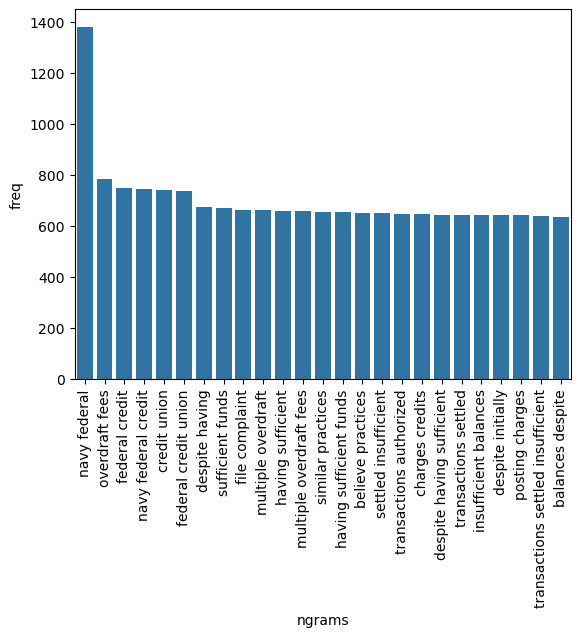

In [44]:
# create bar plot visualization
# ----------
sns.barplot(x="ngrams",    # what goes on the x-axis here?
            y = 'freq',  # what goes on the y-axis here?
            data=df_ngram[0:25])
plt.xticks(rotation=90
           )
plt.show()

**CHALLENGE:** Adjust the code above to visualize the most popular unigrams and 4-grams. What is the tradeoff involved with increasing n?

In [17]:
# adjust to count unigrams 
# ----------
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(1,1))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # why do you need to specify tondense() here?
                                    columns = countvec.get_feature_names_out()) # get features

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


In [18]:
# create a datamframe by summing over the dictionary_dataframe from above and resetting the index
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view the first few lines
df_ngram.head()

,ngrams,freq
0,transactions,2025
1,fees,1544
2,funds,1529
3,federal,1411
4,navy,1399


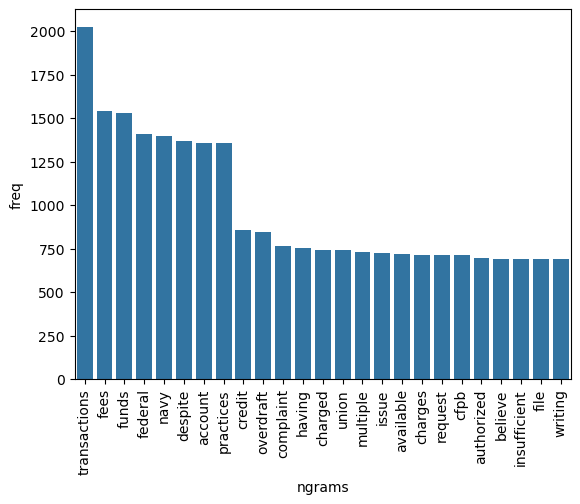

In [19]:
sns.barplot(x="ngrams",    # what goes on the x-axis here?
            y = 'freq',  # what goes on the y-axis here?
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

In [20]:
# adjust to count 4-grams
# ----------
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(4,4))           # specify bi- and trigrams 

# fit and transform on tokens
ngrams = countvec.fit_transform(cfpb['tokens'])         

# create a dataframe out of ngram sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # why do you need to specify tondense() here?
                                    columns = countvec.get_feature_names_out()) # get features

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


In [21]:
dictionary_dataframe = dictionary_dataframe.replace(r'\bxx+\b',  '', regex=True)
dictionary_dataframe = dictionary_dataframe.replace(r'\bxxxx+\b', '', regex=True)
dictionary_dataframe = dictionary_dataframe.replace(r'\bxxxxxxxx+\b', '', regex=True)
dictionary_dataframe = dictionary_dataframe.replace(r'\bve+\b', '', regex=True)
dictionary_dataframe = dictionary_dataframe.replace(r'\bll+\b', '', regex=True)

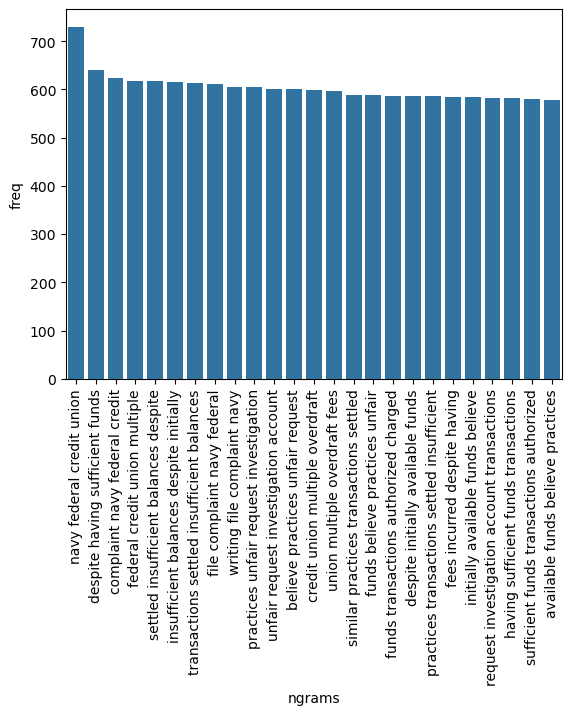

In [22]:
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})

#  sort by frequency 
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)
sns.barplot(x="ngrams",    # what goes on the x-axis here?
            y = 'freq',  # what goes on the y-axis here?
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

**ANSWER**: ...

## Feature Engineering

Last time, we saw some techniques for exploring the text of our data. Specifically, we saw how to find the length of our text and word counts. How can we do this?

In [23]:
# find the character count for each document 
# --------
# apply length function to tokens column to count each character - what 
cfpb['complaint_len'] = cfpb['tokens'].apply(len) 

# view the new feature we just created
cfpb[['tokens', 'complaint_len']]

,tokens,complaint_len
170,On XXXX24 direct deposit 5600 Venmo account I ...,671
268,My loans serviced Aidvantage \n\n I enrolled S...,774
396,Due financial hardship I government worker aff...,378
525,Mohela failed communicate important accurate i...,1439
526,The website redesign nonfunctional banking web...,801
...,...,...
107015,I submitting formal complaint Navy Federal Cre...,438
107024,I writing file complaint Navy Federal Credit U...,404
107074,I writing file complaint Navy Federal Credit U...,395
107076,I writing file complaint Navy Federal Credit U...,405


In [24]:
# find the word count for each document 
# --------
# apply length function to tokens column to count words -- you will need to split the text to count words
cfpb['word_count'] = cfpb['tokens'].apply(lambda x: len(str(x).split()))

# view
cfpb[['tokens', 'complaint_len', 'word_count']]

,tokens,complaint_len,word_count
170,On XXXX24 direct deposit 5600 Venmo account I ...,671,95
268,My loans serviced Aidvantage \n\n I enrolled S...,774,108
396,Due financial hardship I government worker aff...,378,56
525,Mohela failed communicate important accurate i...,1439,201
526,The website redesign nonfunctional banking web...,801,112
...,...,...,...
107015,I submitting formal complaint Navy Federal Cre...,438,56
107024,I writing file complaint Navy Federal Credit U...,404,52
107074,I writing file complaint Navy Federal Credit U...,395,51
107076,I writing file complaint Navy Federal Credit U...,405,52


We also covered subjectivity and sentiment:

In [25]:
# create polarity and subjectivity features
# --------
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cfpb['subjectivity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
cfpb[['tokens', 'complaint_len', 'word_count', 'polarity', 'subjectivity']]

,tokens,complaint_len,word_count,polarity,subjectivity
170,On XXXX24 direct deposit 5600 Venmo account I ...,671,95,0.150000,0.475000
268,My loans serviced Aidvantage \n\n I enrolled S...,774,108,0.270000,0.527778
396,Due financial hardship I government worker aff...,378,56,-0.116667,0.226190
525,Mohela failed communicate important accurate i...,1439,201,-0.146154,0.367949
526,The website redesign nonfunctional banking web...,801,112,0.013528,0.392118
...,...,...,...,...,...
107015,I submitting formal complaint Navy Federal Cre...,438,56,-0.066667,0.375000
107024,I writing file complaint Navy Federal Credit U...,404,52,-0.066667,0.375000
107074,I writing file complaint Navy Federal Credit U...,395,51,-0.080000,0.450000
107076,I writing file complaint Navy Federal Credit U...,405,52,-0.066667,0.375000


### Build a Dictionary

Before we continue, let's take the top 25 n-grams we found earlier and turn them into their own dataframe. We'll return to these later.

In [26]:
# build a dictionary
# --------

# create a count of words after dropping stop words
countvec = CountVectorizer(stop_words=list(STOP_WORDS),  # use our list of stop words
                           ngram_range=(2,3))            # specify bi- and tri-grams

# apply countvec function to our tokenized data
ngrams = countvec.fit_transform(cfpb['tokens'])

# create dictionary - but note 
dictionary_dataframe = pd.DataFrame(ngrams.todense(), 
                                    columns = countvec.get_feature_names_out())


# create ngram frequency dataframe by summing over dictionary dataframe
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)

# view just a subset
top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've', 'xx', 'xxxx', 'xxxxxxxx'] not in stop_words.
  warnings.warn(


,navy federal,overdraft fees,federal credit,navy federal credit,credit union,federal credit union,despite having,sufficient funds,file complaint,multiple overdraft,...,settled insufficient,transactions authorized,charges credits,despite having sufficient,transactions settled,insufficient balances,despite initially,posting charges,transactions settled insufficient,balances despite
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Challenge: Topic Modeling

Using the code we went over from the last lab, make a dataframe with 5 LDA generated topics. Then, create a topic model using [Non-Negative Matrix Factorization](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) and print out the words associated with the first 5 topics. NMF is another algorithm that is frequently used for topic modeling. 

**QUESTION:** Do you get similar topics as with your LDA topics? 

In [27]:
# first, let's define a function to print the top words that we'll use in our model
# --------

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [30]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = cfpb['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer= rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern=None)       # what can we add here to remove the Warning? Is this necessary?


# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)  # specify correct data ehre

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense() # how do we densify this matrix?

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components= 5,            # specify 5 components
                                max_iter= 20,            # specify 20 iterations 
                                random_state=0) # set seed of 0 for  reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,  # specify LDA model
                tf_feature_names,  # specify feature names vector
                20)  # specify that we want to see 20 words here
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df


Topic #0:
consumers concerns oop exploit neglected light highlighting particularly indicate extensive lawsuit express true low protect unfeasible offenders populate handling repeat

Topic #1:
l reimburse changed numerous zelle multipleoverdraft decline randomly u dating tip item              majority friend 6000 restaurant dropping regret bar

Topic #2:
   money bank account 

  nt payment told fargo check received mohela said called wells times xxxxyear payments card time

Topic #3:
transactions fees practices despite navy federal funds overdraft union having credit insufficient incurred aligns lagged authorized similar sufficient unfair initially

Topic #4:
lawsuit delays mirrors federals filing respectfully question specific initiated thorough 

  situation formal repeatedly writting regard 1500 availablethis 8000 highlighted



,0,1,2,3,4
0,0.029410,0.029411,0.881451,0.029892,0.029835
1,0.023072,0.023071,0.903319,0.027465,0.023073
2,0.027825,0.027826,0.888721,0.027800,0.027828
3,0.021991,0.021987,0.910275,0.023726,0.022022
4,0.023046,0.023048,0.904965,0.025894,0.023047
...,...,...,...,...,...
995,0.030624,0.030402,0.031183,0.613484,0.294307
996,0.029041,0.029041,0.029049,0.883828,0.029041
997,0.029377,0.029377,0.029386,0.882482,0.029377
998,0.029814,0.029814,0.029822,0.880736,0.029814


In [34]:
#
# Non-Negative Matrix Factorization (NMF)
# ---------------------------------------

# pre-processing
# --------
# create a new data object called X
X = cfpb['tokens']

# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
nmf = NMF(n_components= 5,             # specify the number of components to 5
          init= 'random',             # specify a random initalization method
          random_state=1)  # set a seed for reproducibility

# fit NMF model to our dense matrix
nmf = nmf.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(nmf,               # specify model
                tf_feature_names,  # specify feature names vector
                100)                # specify how many words we want to see


# now transform our data using the lda model and create a dataframe
nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
nmf_topic_dist_df


Topic #0:
transactions practices despite navy federal funds fees lagged aligns incurred union investigation insufficient initially settled similar posting request findings credits unfair balances sufficient recent authorized file credit having believe writing cfpb charges available issue multiple complaint charged overdraft account transaction lagging postings finding balance overdrafts occurred issues incurreddespite practice settle creditsthis m fundsi cfbp want initial filing significant align iam cfpd claim l changes withe fund trans avaliable feed settles post nfcu accounts action insignificant requesting 

  authorize delayed tranactions finds publish thank crddit lag fee beleive delays complain like theses reguarding tractions feesi federl suficient filling authorised cfpa hi

Topic #1:

  consistent deceptive adequate identified appears unfairly formally assessed applied delayed fees time overdraft having practices despite funds transactions available posting insufficient suff

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,0,1,2,3,4
0,0.000844,0.000000,0.001057,0.038282,0.022951
1,0.000000,0.000000,0.006001,0.000000,0.084592
2,0.000000,0.000000,0.000572,0.000664,0.066963
3,0.000233,0.000000,0.002605,0.000000,0.118130
4,0.000009,0.000000,0.001408,0.044496,0.039570
...,...,...,...,...,...
995,0.018555,0.067411,0.003202,0.000270,0.011498
996,0.051170,0.000000,0.000000,0.000000,0.000000
997,0.050773,0.000000,0.000000,0.000000,0.000000
998,0.046210,0.002679,0.001225,0.000000,0.000000


**ANSWER**: 

## Classification

Now we're ready to move to classification! We are going to examine how different featurization techniques compare. Create a list with the following:
 * Text Engineered Features
 * Text Engineered Features + Topic Model
 * Non-Text Features only
 * Non-Text Features + Text Engineered Features
 * Tf-idf
 * Non-Text Features + tf-idf
 * Top 25 n-gram
 * Non-Text Features + Top 25 n-gram
 
You'll need to use pandas to create and .`join()` these different dataframes together. Also be sure to use `reset_index()` as necessary. Once you've created each of these dataframes (or arrays!) you should loop through all of them, train a supervised learning algorithm (like logistic regression or a decision tree classifier), and plot confusion matrices. Once you do this, think about which featurization technique worked the best, and whether combining text and non-text features was helpful. For now, don't worry about hyperparameter tuning or feature selection, though you would do these in practice.

In [35]:
# let's first take a look at the column names to get a sense of what we have
# --------
cfpb.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'tokens',
       'complaint_len', 'word_count', 'polarity', 'subjectivity'],
      dtype='object')

In [38]:
#
# pre-processing for a classification model
# ---------------------------------------


# Engineered Text Features
# --------
# select engineered text features   # specify 4 engineered text features from above
engineered_features = cfpb[['complaint_len', 
                            'word_count', 
                            'polarity', 
                            'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
# --------
# combine results from our topic model + engineered features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True)) # engineered features


# Non-text features
# --------
# select non-text features
non_text_features = cfpb[['Company public response',  # specify 7 non-text features
                          'Company',
                          'State', 
                          'Consumer consent provided?',
                          'Submitted via', 
                          'Company response to consumer',
                          'Timely response?']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True) # get dummies of non_text_features



# Non-text features + engineered features
# --------
# combine non-text features + engineered features with topics
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(non_text_features)


# Non-text features + tfidf
# --------

# create dataframe of tf-idf 
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),                # specify matrix
                        columns = tf.get_feature_names_out())  # get feature names from tf object

# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df) # specify tf-idf


# Non-Text Features + Top 25 n-gram
# --------
# combine non-text features and Top 25 ngrams (from above)
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams) # specify top_25_ngrams


In [45]:
# more pre-processing 
# --------

# DESCRIBE WHAT IS HAPPENING AT EACH STEP WITH ANNOTATIONS

# ...
dataframes = [engineered_features,   
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
              top_25_ngrams,
              non_text_with_ngrams]


# ...
featurization_technique = ['Engineered Text Features',
                           'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                           'Top 25 N-Gram Features',
                           'Non-Text + Top 25 N-Gram Features']

# model initalization and fit
# --------

# ...
lb_style = LabelBinarizer()

# ...
y = cfpb['Product_binary'] = lb_style.fit_transform(cfpb["Product"])


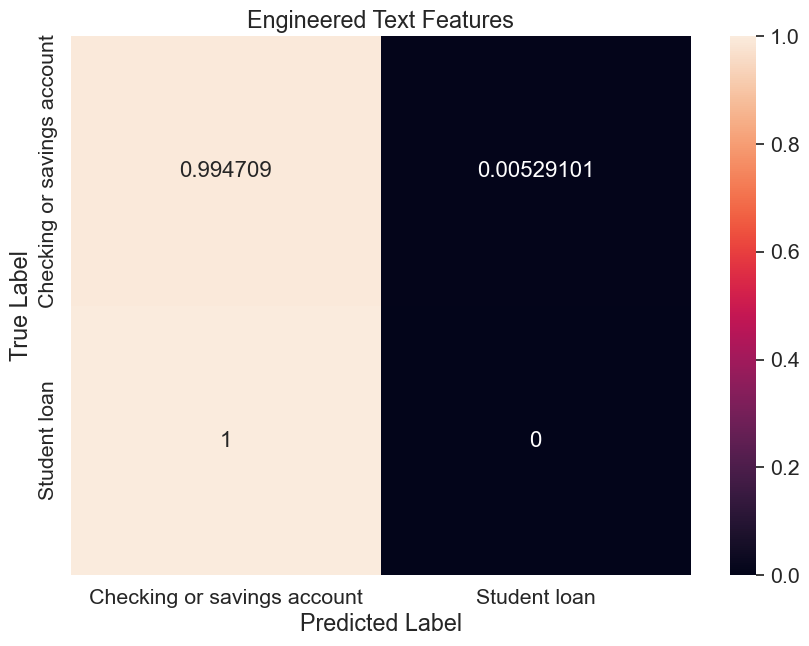

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


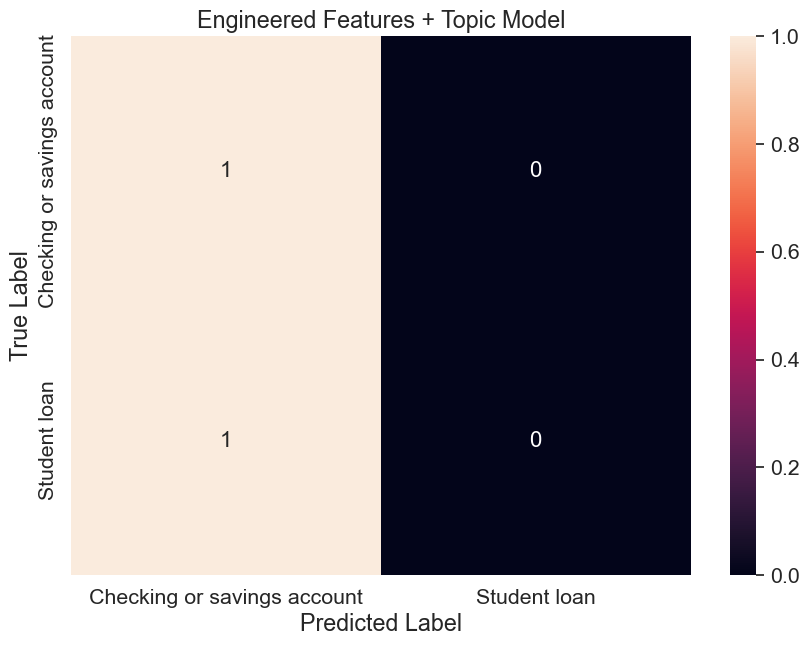

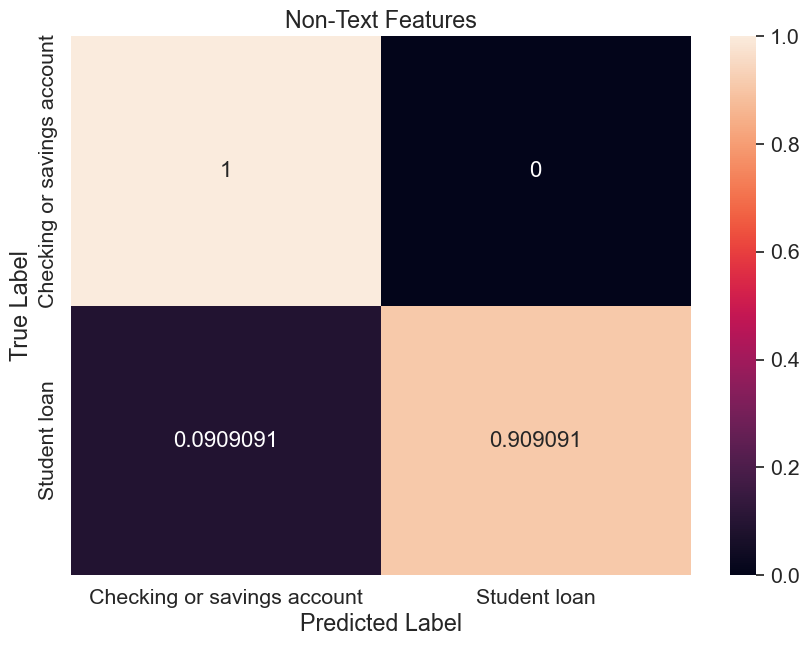

ValueError: could not convert string to float: 'Company believes it acted appropriately as authorized by contract or law'

In [52]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size=.80,               # specify train split of 80%
                                                        test_size=.20,               # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression()

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,          # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the training dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)      # predict on test data
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize= 'true')             # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,                # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Checking or savings account", 
                                  1: "Student loan"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Checking or savings account", "Student loan"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion

In general, combing text with non-text features will improve a classifier's performance. However this isn't automatic - in some cases you can actually degrade a classifier's performance by adding in more features (e.g., Non-text alone out-performed Non-text + Engineered).

In this case, our engineered features were too quick to predict "checking or savings account" and our tf-idf alone performed just as well as tf-idf + non-text features. 

However, non-text features + ngrams and tf-idf tied in accuracy performance. We might prefer the former approach because it is computationally cheaper, and likely easier to explain.

## Naive Bayes

[Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable) is a supervised learning algorithim that leverages [Bayes’ theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) that is commonly used to solve classification problems. The "naive" of Naive Bayes comes from its assumption of conditional independence between every feature pair during estimation. In the context of Natural Language Processing, this means it assumes the probabilty a word will be chosen is independent of other words in the corpus. While this strong assumption seems to violate what we know about language, the model has proven time and time again to be very effective. 

One important note, however, is that although naive Bayes is known as a decent classifier, [it is known to be a bad estimator](https://scikit-learn.org/stable/modules/naive_bayes.html#:~:text=Naive%20Bayes%20methods%20are%20a,value%20of%20the%20class%20variable.), so the probability outputs from `predict_proba` are not to be taken too seriously.

Let's see how it compares to the logit models we just implemented. Note that we'll use the last dataframe (X_train) that was generated from the loop above ("Non-Text + Top 25 N-Gram Features"), so we should compare our results to the last confusion matrix.

One last thing to note is that the library name for each model refers to the type of data used, not necessarily the outcome. So, we'll use Multinomial Naive Bayes because it works for text data not because we are modeling a multi-cateogry outcome. See this [Stack Overflow post](https://stackoverflow.com/questions/65627712/multinomialnb-or-gaussiannb-or-categoricalnb-what-to-use-here) for more on the difference between the Naive Bayes libraries.

In [54]:
# initialize the Multinomial Naive Bayes algorithim
# ----------
# load library
from sklearn.naive_bayes import MultinomialNB

# initialize the native bayes estimator
nb = MultinomialNB(alpha = 1 )   # see how performance changes with different levels of smoothing

# fit it on the training data
# ----------
nb_model = nb.fit(X_train, 
                  y_train.ravel()) # use the .ravel() method to flatten flatten multi-dimensional to 1-dimensional array

# predict on test dataset
# ----------
nb_pred = nb_model.predict(X_test) 

ValueError: could not convert string to float: 'Company believes it acted appropriately as authorized by contract or law'

In [ ]:
# print average accuracy
# ----------
print(np.mean(nb_pred == y_test))

# create a confusion matix
# ----------
nb_cf_matrix = confusion_matrix(...,  # specify test and predictions to compare
                                ..., 
                                normalize = "true")

# print confusion matrix scores
print(nb_cf_matrix)

In [ ]:
# convert to dataframe for visualization
# ----------
nb_df_cm = pd.DataFrame(...,       # set data to convert to dataframe
                        range(2),
                        range(2))

# visualize
nb_df_cm

**QUESTION:** How does this compare to the Logit classification model from above?

In [ ]:
# create confusion matrix using Seaborn code
# ----------
# add indices and labels
nb_df_cm = nb_df_cm.rename(index=str, columns={0: "Checking or savings account", 
                                               1: "Student loan"})

nb_df_cm.index = ["Checking or savings account", "Student loan"]

# specifyc figure parameters
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

# specify figure using seaborn library
sns.heatmap(nb_df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')  # prevent scientific notation

# figure labels
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**ANSWER:** ...

---
Notebook developed by Aniket Kesari. Modified by Prashant Sharma (2023) and by Kasey Zapatka (2024).